# EDA for JPX Tokyo Stock Exchange Prediction

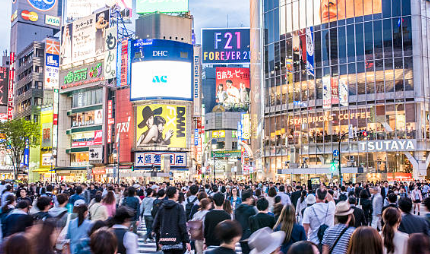


Thank you for your checking this notebook.

This is my EDA notebook for "JPX Tokyo Stock Exchange Prediction" competition [(Link)](https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/overview).

I will check the data of stock price which would be the main data for training and will use cudf for that to reduce executing time. 

Also I would like to summarize key events which might be or would be affected to Japan market.

If you think this notebook is interesting, please leave your comment or question and I appreciate your upvote as well. :) 

<a id='top'></a>
## Contents
1. [Import Library & Set Config](#config)
2. [Load Data](#load)
3. [Stock Price History - Average](#avg)
4. [Stock Price History - Average by 17section codes](#avg17)
4. [Key Events impacted in Japan Market](#key)
4. [Future Key Events in Japan Market](#future)
6. [Conclution](#conclution)
7. [Reference](#ref)

<a id='config'></a>

---
# 1. Import Library & Set Config
---

[Back to Contents](#top)

In [ ]:
# === General ===
import sys, warnings, time, os, copy, gc, re, random, pickle, cudf
warnings.filterwarnings('ignore')
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
# pd.set_option("display.max_colwidth", 10000)
import seaborn as sns
sns.set()
from pandas.io.json import json_normalize
from pprint import pprint
from pathlib import Path
from tqdm import tqdm
tqdm.pandas()
from datetime import datetime, timedelta

# Pre-Processing
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold

In [ ]:
DEBUG = True
PATH_INPUT = r'../input/jpx-tokyo-stock-exchange-prediction'

<a id='load'></a>

---
# 2. Load Data

Based on the [Data Description](https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/data), I am looking into the detail of following files as first step.

This is the competition to predict future return of investment. So stock price info and general info about company would be enough for baseline.

- ../train_files/stock_prices.csv: Price info of stock covering the main training period.
- ../supplemental_files/stock_prices.csv: Price info of stock updated with new data during the main phase of the competition in early May, early June, and roughly a week before the submissions are locked.
- ../stock_list.csv: Mapping between the SecuritiesCode and company names, plus general information about which industry the company is in.


---

[Back to Contents](#top)

In [ ]:
dfPriceTrain = cudf.read_csv(PATH_INPUT + r'/train_files/stock_prices.csv')
dfPriceTrain['Date'] = cudf.to_datetime(dfPriceTrain['Date'])
dfPriceTrain

In [ ]:
dfPriceSuppl = cudf.read_csv(PATH_INPUT + r'/supplemental_files/stock_prices.csv')
dfPriceSuppl['Date'] = cudf.to_datetime(dfPriceSuppl['Date'])
dfPriceSuppl

In [ ]:
dfList = cudf.read_csv(PATH_INPUT + r'/stock_list.csv')
dfList

<a id='avg'></a>

---
# 3. Stock Price History - Average

First, I will check the history of average stock price in the past.

Not only just average price but also apply rolling average, logarithmic conversion, daily difference and so on will be checked.

---

[Back to Contents](#top)

In [ ]:
dfPriceAll = cudf.concat([dfPriceTrain, dfPriceSuppl], axis=0)
dfPriceAll

In [ ]:
dfPriceAllStat = dfPriceAll.groupby('Date').agg(['mean', 'sum']).sort_index()
dfPriceAllStat

In [ ]:
dfPriceAllStat.loc[:,('Close', 'mean')].to_pandas().plot(title= "Avg. of close price", figsize=(20,6), legend=False)

In [ ]:
dfPriceAllStat.loc[:,('Close', 'mean')].to_pandas().rolling(window=20).mean().plot(title= "Rolling Avg. 20 days of close price", figsize=(20,6), legend=False)

In [ ]:
np.log1p(dfPriceAllStat.loc[:,('Close', 'mean')].to_pandas().rolling(window=20).mean()).plot(title= "log1p of Rolling Avg. 20 days of close price", figsize=(20,6), legend=False)

In [ ]:
x = dfPriceAllStat.loc[:,('Close', 'mean')].to_pandas().interpolate()
decompose_result = sm.tsa.seasonal_decompose(x, period=365, extrapolate_trend='freq')

# Prepare plot area
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 10), sharex=True)
# Observation of data
axes[0].set_title('Observed')
axes[0].plot(decompose_result.observed)
# Trend of data
axes[1].set_title('Trend')
axes[1].plot(decompose_result.trend)
# Seasonality of data 
axes[2].set_title('Seasonal')
axes[2].plot(decompose_result.seasonal)
# Residual of data
axes[3].set_title('Residual')
axes[3].plot(decompose_result.resid)
plt.show()

- First peak was beginning of 2018, then switch to down trend.
- End of 2019, there was little bit stronger decreasing.
- About Q1. 2020 was showing very strong decreasing but it was also the timming of trend change.
- Positive trend was continuing until arround Q3. 2021 and touch to 2nd peak.
- Currently negative trend is on going.


In [ ]:
dfPriceAllStat.loc[:,('Volume', 'sum')].to_pandas().plot(title= "Sum of Volume", figsize=(20,6), legend=False)

In [ ]:
dfPriceAllStat.loc['2020.06.01':'2020.12.31',('Volume', 'sum')].to_pandas().plot(title= "Sum of Volume '2020.06.01':'2020.12.31'", figsize=(20,6), legend=False)

- Begining of 2018 when close price touch to peak, the volume was also showing peak.
- Q1 2020,the volmue was increasing because of short of stock a lot due to COVID pandemic.
- Oct. 2020, there was 0 volumne day.

In [ ]:
dfPriceAllStat.loc[:,('Target', 'sum')].to_pandas().plot(title= "Sum of Target", figsize=(20,6), legend=False)

In [ ]:
dfPriceAllStat.loc[:,('Target', 'sum')].to_pandas().rolling(window=20).mean().plot(title= "Rolling Avg. 20 days Sum of Target", figsize=(20,6), legend=False)

In [ ]:
dfPriceAllStat.loc['2018.01.01':'2018.06.30',('Target', 'sum')].to_pandas().plot(title= "Sum of Target '2018.01.01':'2018.06.30'", figsize=(20,6), legend=False)

In [ ]:
dfPriceAllStat.loc['2018.10.01':'2018.12.31',('Target', 'sum')].to_pandas().plot(title= "Sum of Target '2018.10.01':'2018.12.31'", figsize=(20,6), legend=False)

In [ ]:
dfPriceAllStat.loc['2020.01.01':'2020.06.30',('Target', 'sum')].to_pandas().plot(title= "Sum of Target '2020.01.01':'2020.06.30'", figsize=(20,6), legend=False)

- Q1 & Q4 in 2018 and Q1 in 2020, there were big fractuation of sum of target.
- It was tend to have the big increasing after big decreasing.

<a id='avg17'></a>

---
# 4. Stock Price History - Average by 17section codes

Second, I will categorize target stocks by 17 section codes from stock_list and check the trend of each category.

---

[Back to Contents](#top)

In [ ]:
dfPriceAllsec17 = dfPriceAll.merge(dfList, on='SecuritiesCode')
dfPriceAllsec17

In [ ]:
dfPriceAllsec17Stat = dfPriceAllsec17.groupby(['Date', '17SectorName']).agg(['mean', 'sum']).sort_index()
dfPriceAllsec17Stat

In [ ]:
df = dfPriceAllsec17Stat.loc[:,('Close_x', 'mean')].to_pandas().reset_index()
df.columns = ['Date', '17Sectorname', 'closePriceMean']
df['closePriceMean'] = df['closePriceMean'].interpolate()
plt.figure(figsize=(16, 10))
p = sns.lineplot(x='Date', y='closePriceMean', hue='17Sectorname', data=df)
p.set_title("Average close price by 17 sectors")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
df['closePriceRollingMean'] = df['closePriceMean'].rolling(window=10).mean()
plt.figure(figsize=(16, 10))
p = sns.lineplot(x='Date', y='closePriceRollingMean', hue='17Sectorname', data=df)
p.set_title("Average close price rolling mean by 17 sectors")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
f, ax = plt.subplots(figsize=(16, 10))
sns.boxplot(x='closePriceMean', y='17Sectorname', data=df, whis=[0, 100], width=.6, palette="vlag")
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [ ]:
df2 = dfPriceAllsec17Stat.loc[:,('Target', 'sum')].to_pandas().reset_index()
df2.columns = ['Date', '17Sectorname', 'targetSum']
df2['targetSum'] = df2['targetSum'].interpolate()

f, ax = plt.subplots(figsize=(16, 10))
sns.boxplot(x='targetSum', y='17Sectorname', data=df2, whis=[0, 100], width=.6, palette="vlag")
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [ ]:
f, ax = plt.subplots(figsize=(16, 10))
sns.barplot(x='targetSum', y='17Sectorname', palette="rocket", data=df2)

- Most of all segments sum of target were more than 0.
- Only BANK segment sum of target was less than 0. So this segment might be tend to in bottom 100.   

<a id='key'></a>

---
# 5. Key Events impacted in Japan Market
- On Jun. 24th 2016, due to the decision of GB to leave EU,　NIKKEI 225 index touched to 14,952 JPY which was the lowest value in last 20 months.
- On Nov. 9th 2016, Mr. Trump became president of US and NIKKEI 225 index dowm more than 1,000 JPY.
- On Feb. 2018, VIX index increased and lead the negative impact on market globally. 
- On Mar. 23rd 2018, due to US-China trade friction, NIKKEI 225 index donw 974 JPY.
- On Oct. 2018, USD was becoming stronger (JPY was becoming weaker) and NIKKEI 225 index touch to 24,270 JPY which was the highest calue in last 27 years.
- On Oct. - Dec. 2018, Due to sales action by overseas investors, NIKKEI 225 index decreased more than 20%.
- On Oct. 2019, consumption tax in Japan increased to 10% from 8%.
- From Feb. 2020, COVID19 pandemic hit globally and NIKKEI 225 index also down dramatically.
- On Sep. 3rd 2020, NIKKEI 225 index back to 23,465 JPY which was same level with 6 months ago because of credit relaxation in each countries.
- On Sep. 16th 2020, Mr. Suga took over the responsibility as PM from former PM. Mr. Abe. 
- On Dec. 7th 2020, NIKKEI 225 index hit to 26,894 JPY which was the highest value in last 29 years.
- On Feb. 15th 2021, NIKKEI 225 index over 30,000 JPY which was the highest value in last 30 years.
- On Apr. 2021, 3rd state of emergency was announed and into negative impact.
- On Jul. - Aug. 2021, COVID pandemic hit supply chain of automotive industry and Japanese car manufacture like TOYOTA announed to reduce their production capacity. This lead further negative impact on market.
- On Sep. 2021, PM. Mr. Suga announed to not nominate himself to next race and this effected positively to the market because of wish to new growth strategy by new goverment.
- On Oct. 4th 2021, Mr. Kishida took over the responsibility as PM from former PM. Mr. Suga.
- On Nov. 2021, new COVID variant "Omicron" spread globally and the market was stagnated.
- On Feb. 24th 2022, Russia started to invade Ukraine.

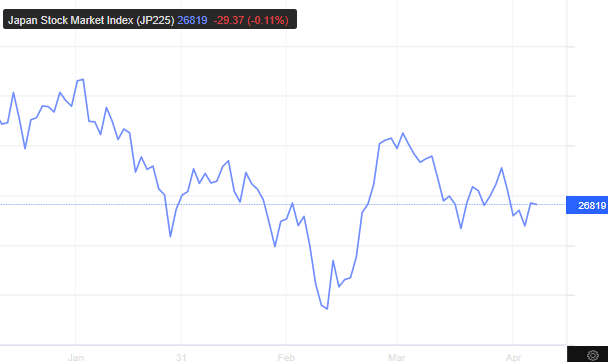

- On Mar. 2022, the risk due to the war and increasing of resource price was still under consideration. However NIKKEI 225 index increased based on positive situation of market in US and keeping JPY weaker to USD.
- On Apr. 4th 2022, Japan stock market was restructured into three new market segments. [Link](https://www.jpx.co.jp/english/equities/market-restructure/index.html)

---

[Back to Contents](#top)

<a id='future'></a>

---
# 6. Future Key Events 
- On Jun. 26th - 28th 2022, G7 meeting in Germany
- On Jun. 17th 2022, Bank of Japan announce result of discussion Financial strategy.
- On Jul. 2022, House of Councillors election.
- On Sep. 2022, Tokyo Game Show open.
- On Oct. 30-31st 2022, G20 meeting in Indonesia.
- On Oct. 3rd 2022, Bank of Japan announce result of investigation about business and economy in Japan for short term. 

---

[Back to Contents](#top)

<a id='conclution'></a>

---
# 7. Conclution

- The trend of price of target 2,000 stocks were very similar to the trend of NIKKEI 225 trend.
- There were significant up and down based on some economical or political events during the period of training data.
- The sum of target value during the traing data was positive. It's interesting it would be same during validation period or not.
- As competition owner mentioned, it would be the key to prepare a robust solution which would not be affected the fractuation of price it self.

---

[Back to Contents](#top)

<a id='ref'></a>

---
# 8. Reference
1. [Python: statsmodels で時系列データを基本成分に分解する](https://blog.amedama.jp/entry/sm-decompose-series)](https://teratail.com/questions/368560)
2. [TypeError: seasonal_decompose() got an unexpected keyword argument 'freq'の解決方法](https://teratail.com/questions/368560)
---

[Back to Contents](#top)